# Bike Sharing Demand

### Import Libraries

In [551]:
import pandas as pd      # for data manipulation and analysis
import numpy as np       # for numerical computing
import matplotlib.pyplot as plt     # for data visualization
import matplotlib.dates as mdates   
import seaborn as sns    # for advanced data visualization
import sklearn           # for machine learning algorithms
import statsmodels.api as sm        # for statistical models and tests
import scipy.stats as stats         # for scientific computing and statistics
import random
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier


# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from termcolor import colored
import pylab
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso

### Import Data

In [497]:
# Set the file path and name
train_path = './data/train.csv'
test_path = './data/test.csv'

# Read the CSV file into a Pandas DataFrame
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Copy of datasets
train = train_df
test = test_df

### Auxiliar Functions

In [498]:
# Function to print main info about the dataset

def ds_info(df):
    print(colored('SIZE' , 'blue', attrs=['bold', 'dark']))
    print(df.size)
    print(colored('\nSHAPE' , 'blue', attrs=['bold', 'dark']))
    print(df.shape)
    print(colored('\nINFO' , 'blue', attrs=['bold', 'dark']))
    print(df.info())
    print(colored('\nNULL VALUES' , 'blue', attrs=['bold', 'dark']))
    print(df.isnull().sum())
    print(colored('\nHEAD' , 'blue', attrs=['bold', 'dark']))
    print(df.head())
    print(colored('\nTAIL' , 'blue', attrs=['bold', 'dark']))
    print(df.tail())
    print(colored('\nDESCRIBE - Numerical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe())
    print(colored('\nDESCRIBE - Categorical' , 'blue', attrs=['bold', 'dark']))
    print(df.describe(include='object'))
    
    print(colored('\nUNIQUE ENTRIES IN EACH NUMERICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with numerical data
    num_cols = [col for col in df.columns if df[col].dtype != "object"]
    num_nunique = list(map(lambda col: df[col].nunique(), num_cols))    
    dn = dict(zip(num_cols, num_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dn.items(), key=lambda x: x[1]))
    
    print(colored('\nUNIQUE ENTRIES IN EACH CATEGORICAL COLUMN' , 'blue', attrs=['bold', 'dark']))
    # Get number of unique entries in each column with categorical data
    object_cols = [col for col in df.columns if df[col].dtype == "object"]
    object_nunique = list(map(lambda col: df[col].nunique(), object_cols))
    dc = dict(zip(object_cols, object_nunique))
    # Print number of unique entries by column, in ascending order
    print(sorted(dc.items(), key=lambda x: x[1]))

    
# Function to parse date 
def parse_datetime(data):
    #convert date.datetime to type datetime 
    data.datetime = pd.to_datetime(data.datetime)
    # split in columns
    data['year'] = data['datetime'].dt.year
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['weekday'] = data['datetime'].dt.weekday
    
    
# Function to detect and print outliers 
def detect_outliers(data):
    # mean, standard deviation and 3-sigma of the data
    mean = np.mean(data)
    std = np.std(data)
    threesigma = 3 * std
    
    # print upper, lower boundary and boxplot
    sns.boxplot(data, orient="v")
    plt.show()
    lower, upper = mean-3*std, mean+3*std
    print(f"Upper and lower boundary is: {lower}/{upper}")
    
    # identify outliers and return the outliers
    outliers = [x for x in data if np.abs(x - mean) > threesigma]
    print(f"There are {len(outliers)} outliers based on three-sigma rule")

# Function to delete the outliers 
def delete_outliers(data, df):
    # detecting and dropping outliers 
    original_shape = df.shape
    mean = np.mean(data)
    std = np.std(data)
    outliers = np.abs(data-mean) > (3*std)
    outliers_num = len(train[outliers])
    df.drop(index=data[outliers].index, inplace=True)
    
    # print what was deleted
    print("Number of outliers deleted:", outliers_num)
    print ("Shape of dataframe with Ouliers: ",original_shape)
    print ("Shape of Dataframe After Deleting the Ouliers: ",df.shape)

# Function to plot the Correlation Heatmap
def correlation_heatmap(corr):
    mask = np.array(corr)
    mask[np.tril_indices_from(mask)] = False
    # plot the correlation
    fig,ax= plt.subplots()
    fig.set_size_inches(10,10)
    sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

# Function to calculate RMSLE - Root Mean Squared Logarithmic Error   
def rmsle(y_true, y_pred):
    """
    Custom RMSLE scorer function.
    """
    log_diff = np.log1p(y_pred) - np.log1p(y_true)
    rmsle_score = np.sqrt(np.mean(log_diff**2))
    return rmsle_score

# Define RMSLE scorer
#rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

### Data Information

#### Features

**datetime** - hourly date + timestamp <br>
**season** -  season of the year (1 = spring, 2 = summer, 3 = fall, 4 = winter) <br>
**holiday** - whether the day is considered a holiday (1: holiday, 0: not a holiday) <br>
**workingday** - whether the day is neither a weekend nor holiday (1: working day, 0: not a working day) <br>
**weather:** <br>
  1: Clear, Few clouds, Partly cloudy, Partly cloudy <br>
  2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
  3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
  4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog  <br>
**temp** - temperature in Celsius <br>
**atemp** - "feels like" temperature in Celsius <br>
**humidity** - relative humidity <br>
**windspeed** - wind speed <br>
**casual** - number of non-registered user rentals initiated <br>
**registered** - number of registered user rentals initiated <br>
**count**   - number of total rentals <br>

#### Train Dataset Information

In [499]:
ds_info(train)

SIZE
130632

SHAPE
(10886, 12)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None

NULL VALUES
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype

#### Test Dataset Information

In [500]:
ds_info(test)

SIZE
58437

SHAPE
(6493, 9)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB
None

NULL VALUES
datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

HEAD
              datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  201

## Feature Engineering

As demonstraded previusly, the **datetime** feature is type object, so it must be converted to type datetime. 
Also, some features such as season, holiday, weather and humidity are type int, but they are actually categorical data.

#### Converting to categorical data

In [501]:
# Convert ds to type datetime and split in columns
parse_datetime(train)
parse_datetime(test)

In [502]:
# Train
train["season"] = train.season.map({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter" })
train["weather"] = train.weather.map({1:"Clear",\
                                        2:"Cloudy", \
                                        3:"Light Snow/Rain", \
                                        4:"Heavy Rain/Snow"})
# Test
test["season"] = test.season.map({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter" })
test["weather"] = test.weather.map({1:"Clear",\
                                        2:"Cloudy", \
                                        3:"Light Snow/Rain", \
                                        4:"Heavy Rain/Snow"})

In [503]:
# Train
categoryVariableList = ["hour","weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    train[var] = train[var].astype("category")

In [504]:
# Test
for var in categoryVariableList:
    test[var] = test[var].astype("category")

The column **datetime** is not neccessary anymore and can be dropped

In [505]:
# Train
train = train.drop(['datetime'], axis=1)
# Test
test = test.drop(['datetime'], axis=1)

In [506]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  int64   
 12  month       10886 non-null  category
 13  day         10886 non-null  int64   
 14  hour        10886 non-null  category
 15  weekday     10886 non-null  category
dtypes: category(7), float64(3), int64(6)
memory usage: 842.1 KB


In [507]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   holiday     6493 non-null   category
 2   workingday  6493 non-null   category
 3   weather     6493 non-null   category
 4   temp        6493 non-null   float64 
 5   atemp       6493 non-null   float64 
 6   humidity    6493 non-null   int64   
 7   windspeed   6493 non-null   float64 
 8   year        6493 non-null   int64   
 9   month       6493 non-null   category
 10  day         6493 non-null   int64   
 11  hour        6493 non-null   category
 12  weekday     6493 non-null   category
dtypes: category(7), float64(3), int64(3)
memory usage: 351.0 KB


#### Missing values

An important part of the cleaning and feature engineering process is finding the the missing values of the dataset, but based on previus evaluation using isnull we were able to see the dataset provided doesn't have null values. Let's see is after the feature engineering something changed:

In [508]:
print(train.isnull().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
weekday       0
dtype: int64


In [509]:
print(test.isnull().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
year          0
month         0
day           0
hour          0
weekday       0
dtype: int64


All column still have all values not null in both train and test datasets, so this project will consider no missing values, but some data with zero value in columns such as windspeed could be evaluated to confirm if the 0 is a missing value. 

### Outliers

[Text(0.5, 0, 'Weather'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Count by Weather')]

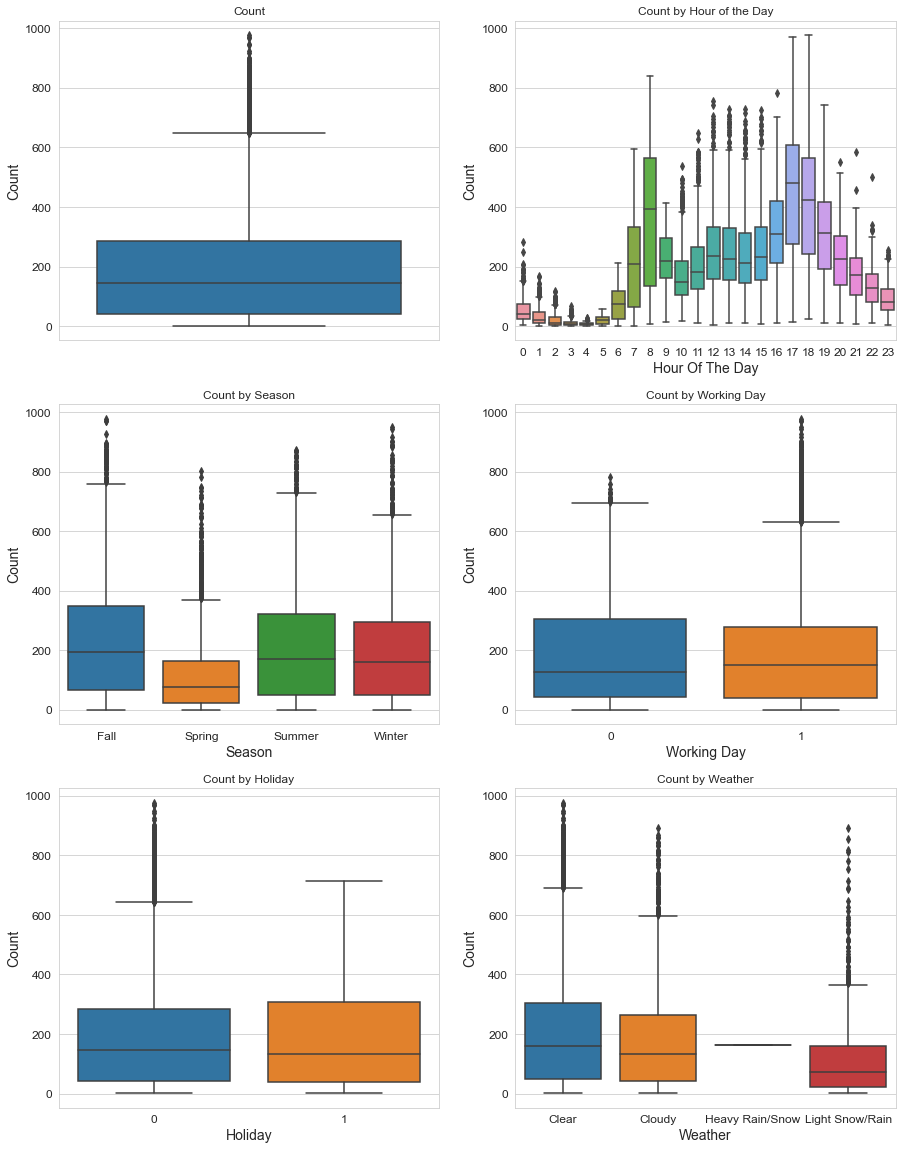

In [510]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 20)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])
sns.boxplot(data=train,y="count",x="holiday",orient="v",ax=axes[2][0])
sns.boxplot(data=train,y="count",x="weather",orient="v",ax=axes[2][1])

axes[0][0].set(ylabel='Count',title="Count")
axes[0][1].set(xlabel='Hour Of The Day', ylabel='Count',title="Count by Hour of the Day")
axes[1][0].set(xlabel='Season', ylabel='Count',title="Count by Season")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Count by Working Day")
axes[2][0].set(xlabel='Holiday', ylabel='Count',title="Count by Holiday")
axes[2][1].set(xlabel='Weather', ylabel='Count',title="Count by Weather")
#axes[2][1].set_xticklabels([])


- datetime - hourly date + timestamp
- season - season of the year (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- holiday - whether the day is considered a holiday (1: holiday, 0: not a holiday)
- workingday - whether the day is neither a weekend nor holiday (1: working day, 0: not a working day)
- weather:
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


Analysis
- The comparison between seasons show spring is the one with lower number of bike rent.
- The boxplot with meaninful information is the Hour of the day, because it shows the busiest hours are 7AM - 8AM and 5PM - 6PM, which means the users mainly rent the bikes to ride to work/school and to return back home at the end of the day.
- Based on boxplots 4 and 5 (Working Day and Holiday), we see most outliers are in working days. The result make sense when looking to Holiday, since all outliers are for non holidays days.
- The last boxploy demonstrates the obvious common sense that most users rent bikes when the weather is Clear and Cloudy (1 and 2), and almost no users when is heavy raining or snowing (3).
- The season with lower number of rentals is oddly Spring and not Winter, but this will be explained further in Visualization.

#### Removing Outliers

It will be used the Three-sigma rule to remove the outliers, also known as the "68-95-99.7 rule". Tree-sigma is a statistical principle that states that for a normal distribution of data, approximately 68% of the data will fall within one standard deviation of the mean, about 95% will fall within two standard deviations, and about 99.7% will fall within three standard deviations.

In practice, this means that if we have a data point that falls outside of three standard deviations from the mean, it is considered an outlier and may be removed from the dataset. This approach assumes that the data follows a normal distribution and that outliers are rare events that are unlikely to occur in the future.

C:\Users\peter\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\peter\Anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


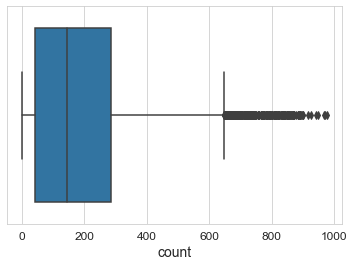

Upper and lower boundary is: -351.8342688102485/734.982532635345
There are 147 outliers based on three-sigma rule


In [511]:
# Kepp a copy of train to compare later
train_with_outliers = train
# Detect Outliers
detect_outliers(train['count'])

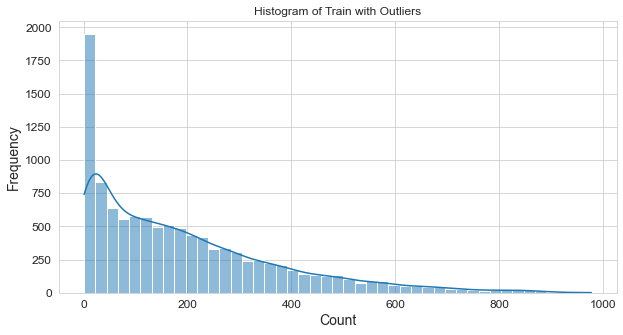

In [512]:
# Plot distribuition with outliers
fig,axes = plt.subplots()
fig.set_size_inches(10, 5)
sns.histplot(train_with_outliers["count"], kde=True)

# Set plot title and labels
plt.title('Histogram of Train with Outliers')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

In [513]:
# Dropping the outliers from train dataset
delete_outliers(train['count'], train)

Number of outliers deleted: 147
Shape of dataframe with Ouliers:  (10886, 16)
Shape of Dataframe After Deleting the Ouliers:  (10739, 16)


The assumption of normality for the dependent variable is not always necessary or desirable for most machine learning techniques. While some traditional statistical models assume normality of the dependent variable, many machine learning algorithms, such as decision trees, random forests, and neural networks, do not rely on this assumption.

However, it's important to note that some algorithms may assume or perform better when the input features or predictors are approximately normally distributed. If the dependent variable exhibits extreme skewness or outliers, it may be beneficial to apply transformations or use alternative models that are more robust to non-normality.

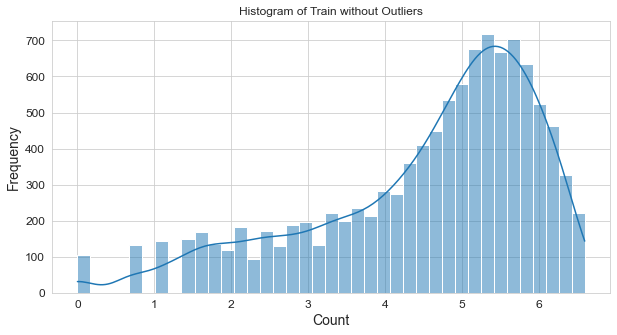

In [514]:
# Plot distribuition of train without outliers
fig,axes = plt.subplots()
fig.set_size_inches(10, 5)
sns.histplot(np.log(train["count"]), kde=True)

# Set plot title and labels
plt.title('Histogram of Train without Outliers')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

**Analisys of emtpty values and 0**

From previus evaluation, Windspeed demonstrated to have 0 values, which could represent just the lack of wind or values to be fullfilled. So it bacame necessary evaluate the number of zeros present in the sample and its impact.
In train datatset Winspeed has 1297 zeros out 9442, which is 14% of the sample, and in test dataset this number is 15%. This hight number of zeros, presuming they are the absense of wind, could affect negatively our model.
Before join the datasets train and test, Windspeed will be predicted and fullfiled using Random Forest model.

In [515]:
train['windspeed'].describe()

count    10739.000000
mean        12.787706
std          8.171075
min          0.000000
25%          7.001500
50%         12.998000
75%         16.997900
max         56.996900
Name: windspeed, dtype: float64

In [516]:
count_zero = (train['windspeed'] == 0).sum()
none_zero = (train['windspeed'] != 0).sum()
print("Count of 0 in Windspeed variable:", count_zero)
print("Count of non zero in Windspeed variable:", none_zero)

Count of 0 in Windspeed variable: 1297
Count of non zero in Windspeed variable: 9442


In [517]:
count_zero = (test['windspeed'] == 0).sum()
none_zero = (test['windspeed'] != 0).sum()
print("Count of 0 in Windspeed variable:", count_zero)
print("Count of non zero in Windspeed variable:", none_zero)

Count of 0 in Windspeed variable: 867
Count of non zero in Windspeed variable: 5626


Filling zeros:

In [518]:

#wind_0 = df[df['windspeed']==0]
#wind_not0 = df[df['windspeed']!=0]
#y_label = wind_not0['windspeed']
#rfc = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=0)
#windcolunms = ['season', 'weather', 'temp', 'atemp', 'humidity', 'hour', 'month']
#rfc.fit(wind_not0[windcolunms], y_label.astype('int'))
#pred_y = rfc.predict(wind_0[windcolunms])
#wind_0['windspeed'] = pred_y
#df_rfw = wind_not0.append(wind_0)
#df_rfw.reset_index(inplace=True)

In [519]:
#train = wind_0_fill(train)
#test = wind_0_fill(test)

### Correlation Analysis

In [520]:
corr_variables = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()

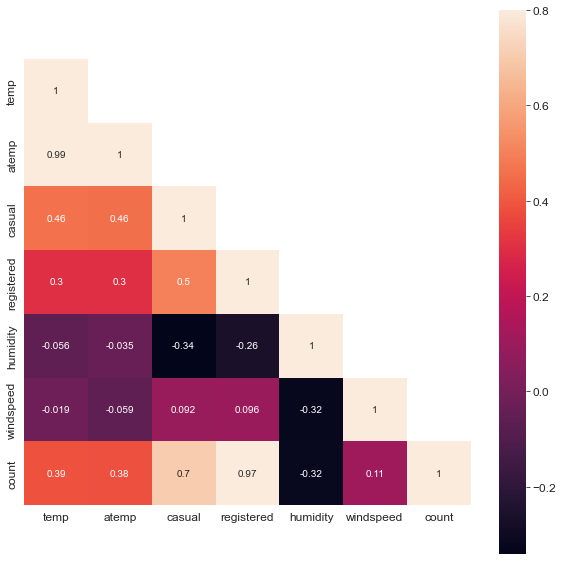

In [521]:
correlation_heatmap(corr_variables)

In [522]:
#plt.figure(figsize=(16,8))
#sns.pairplot(train)
#plt.show()

<AxesSubplot:xlabel='registered', ylabel='count'>

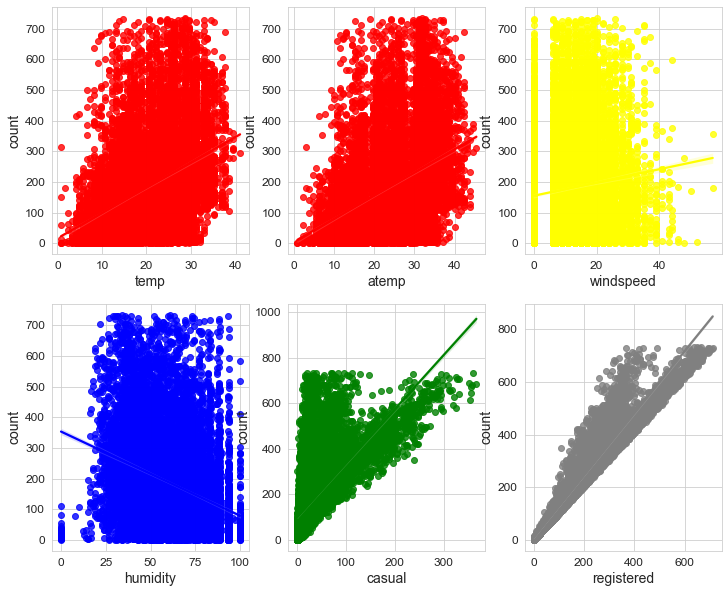

In [523]:
fig,axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(12, 10)
sns.regplot(x="temp", y="count", data=train,ax=axes[0][0], color="red")
sns.regplot(x="atemp", y="count", data=train,ax=axes[0][1], color="red")
sns.regplot(x="windspeed", y="count", data=train,ax=axes[0][2], color="yellow")
sns.regplot(x="humidity", y="count", data=train,ax=axes[1][0], color="blue")
sns.regplot(x="casual", y="count", data=train,ax=axes[1][1], color="green")
sns.regplot(x="registered", y="count", data=train,ax=axes[1][2], color="gray")


Analysis:

In this analisys, it was correlated count with the variables temp, atemp, casual, registered, humidity, windspeed. These are main conclusions found:
- The correlation between count and temp (and atemp) is low it seems to have little dependency on count
- Since count is the result of casual and registerd, we can see correlation of casual agains temp and registered agains temp, we see that registered users have a lower correlation with temperature than casual user, wich makes sense, since the casual users rent the bike for leasure purposes and probably only when the weather is pleasant.
- Temp and atemp have a strong correlation, which in this case could configure multicolinearity in the model, so one of them could be removed from the final model.
- Windspeed doesn't correlate well with any variables, and seems to contain 0 in the sample, which could be considered data missing or just the lack of wind.
- The last two graphs are only to demonstrate count is more affected by registered users, but cannot be used in the final model because would not be available at the time of making the predictions, and are also considered leakage variables.

### Visualization

As explained previusly, COUNT is the result of REGISTERED and CASUAL count, and the graphs below demonstrates the different patterns by hour. The COUNT is similiar to REGISTERED, but because most of users are registered, and their busier times are between 7-8 AM and 4-5 PM, while the busier times for casual users are better distributed during the day, but busiest time betteen 1-2 PM.   

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Casual Count'),
 Text(0.5, 1.0, 'Box Plot On Casual Count Across Hour Of The Day')]

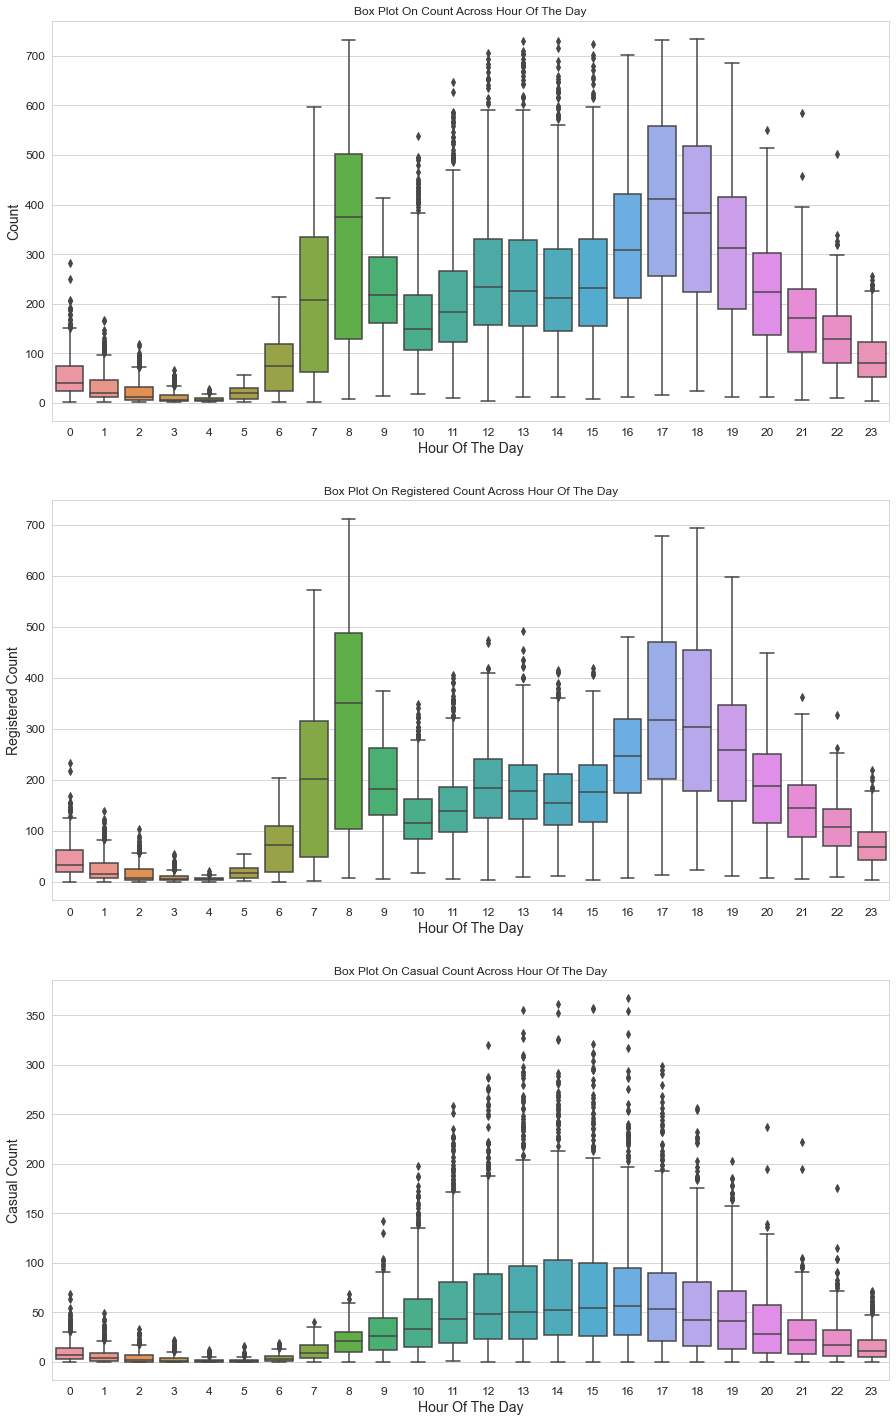

In [524]:
# boxplot of Count, Registered and Casual users by hour
fig, axes = plt.subplots(nrows=3, ncols=1)
fig.set_size_inches(15, 25)

sns.boxplot(data=train,y="count",x="hour",orient="v", ax=axes[0])
sns.boxplot(data=train,y="registered",x="hour",orient="v", ax=axes[1])
sns.boxplot(data=train,y="casual",x="hour",orient="v",ax=axes[2])

axes[0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1].set(xlabel='Hour Of The Day', ylabel='Registered Count',title="Box Plot On Registered Count Across Hour Of The Day")
axes[2].set(xlabel='Hour Of The Day', ylabel='Casual Count',title="Box Plot On Casual Count Across Hour Of The Day")

The graph below demonstraits why the season with less rentals is Spring. Among all seasons, Spring is the one with highest number of Heavy Rain/Snow days, which impacts directly in less rental demand. 

Text(0.5, 0.98, 'Weather count across Seasons')

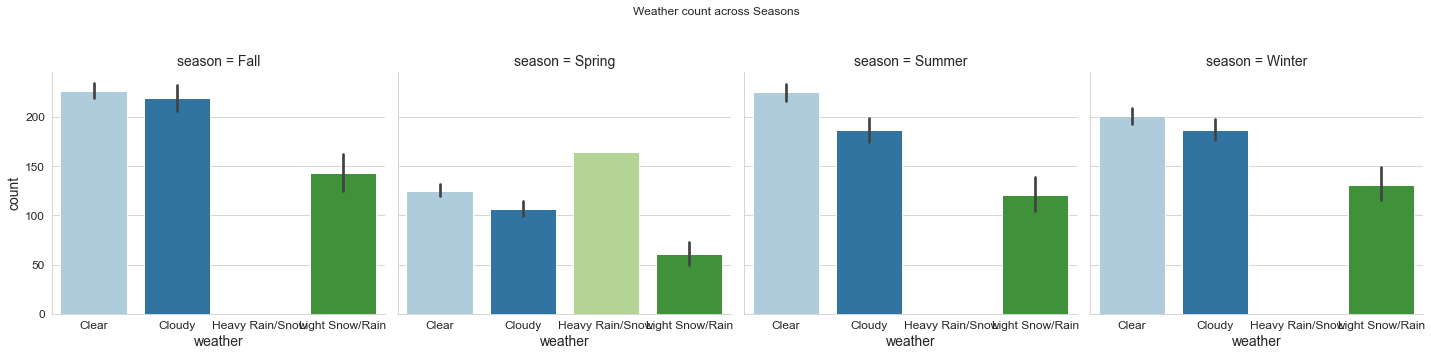

In [525]:
# weather count across seasons
g = sns.catplot(x='weather', y='count', col='season', kind="bar", palette="Paired", data=train)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Weather count across Seasons")

- The graph Count by Season by Hour of the Day demonstrates the distribuition of rentals during the day and proves what 
was already dicussed about Spring season being the least favorite to rent bikes.
- Fall and summer tend to be the one with highest rentals
- The graph by Weekday by Hour of the Day, shows that Saturday and Sunday have cleary a different pattern then the weekday user, with most users renting from 11 AM to 4 PM. These weekend users rent bikes for leasure, not to transport for work (8 AM and 6 PM).
- The weekend users also have similar shape when looking to the last graph, "Count Register vs Casual", in Casual line. This probably shows that Registered users are the ones that use bikes during workdays and the casual users rent on the weekend and when renting in working days, don't need to use as transport to work.

[Text(0.5, 0, 'Hour of the Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Count of Registered vs Casual by Hour of the Day')]

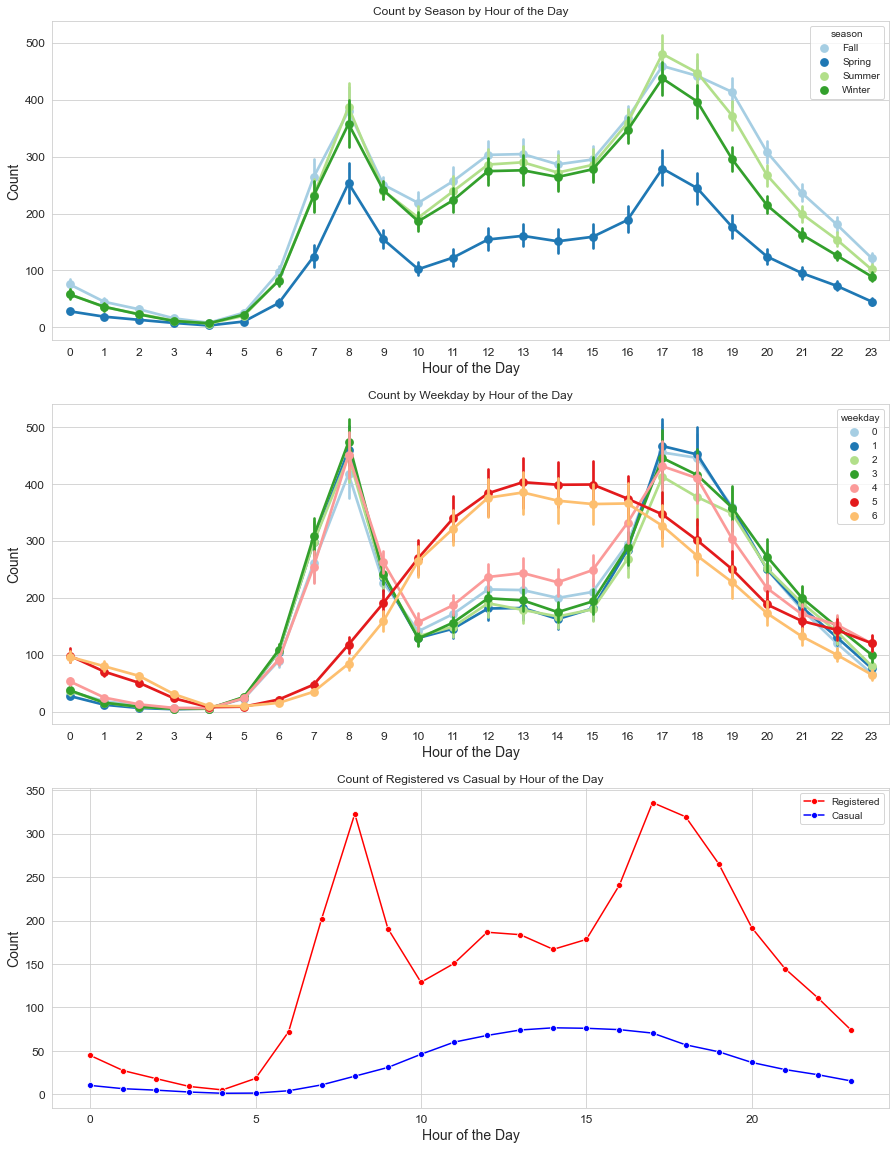

In [526]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(15,20)
sns.pointplot(x='hour',y='count',hue='season',join=True, data=train, palette="Paired", ax=ax1)
sns.pointplot(x='hour',y='count',hue='weekday',join=True, data=train, palette="Paired", ax=ax2)
sns.lineplot(x='hour', y='registered', data=train, color='red',label='Registered', marker='o', ax=ax3, ci=None)
sns.lineplot(x='hour', y='casual', data=train, color='blue', label='Casual', marker='o', ax=ax3, ci=None)
ax3.set_ylabel('Count')

ax1.set(xlabel='Hour of the Day', ylabel='Count',title="Count by Season by Hour of the Day")
ax2.set(xlabel='Hour of the Day', ylabel='Count',title="Count by Weekday by Hour of the Day")
ax3.set(xlabel='Hour of the Day', ylabel='Count',title="Count of Registered vs Casual by Hour of the Day")

### Model

Quick review of datasets:

In [527]:
train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [528]:
test.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'weekday'],
      dtype='object')

In [529]:
train.shape


(10739, 16)

In [530]:
test.shape

(6493, 13)

In [531]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10739 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10739 non-null  category
 1   holiday     10739 non-null  category
 2   workingday  10739 non-null  category
 3   weather     10739 non-null  category
 4   temp        10739 non-null  float64 
 5   atemp       10739 non-null  float64 
 6   humidity    10739 non-null  int64   
 7   windspeed   10739 non-null  float64 
 8   casual      10739 non-null  int64   
 9   registered  10739 non-null  int64   
 10  count       10739 non-null  int64   
 11  year        10739 non-null  int64   
 12  month       10739 non-null  category
 13  day         10739 non-null  int64   
 14  hour        10739 non-null  category
 15  weekday     10739 non-null  category
dtypes: category(7), float64(3), int64(6)
memory usage: 1.1 MB


In [532]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   holiday     6493 non-null   category
 2   workingday  6493 non-null   category
 3   weather     6493 non-null   category
 4   temp        6493 non-null   float64 
 5   atemp       6493 non-null   float64 
 6   humidity    6493 non-null   int64   
 7   windspeed   6493 non-null   float64 
 8   year        6493 non-null   int64   
 9   month       6493 non-null   category
 10  day         6493 non-null   int64   
 11  hour        6493 non-null   category
 12  weekday     6493 non-null   category
dtypes: category(7), float64(3), int64(3)
memory usage: 351.0 KB


Converting Category variables back to Int64:

In [533]:
train["season"] = train["season"].map({"Spring": 1, "Summer": 2, "Fall": 3, "Winter": 4})

In [534]:
train["weather"] = train["weather"].map({"Clear":1, "Cloudy":2, "Light Snow/Rain":3, "Heavy Rain/Snow":4})

Drop columns from train/test datasets:

In [535]:
drop_columns = ['count', 'casual', 'registered']
X_train = train.drop(drop_columns, axis=1).values
X_train.shape

(10739, 13)

In [536]:
X_test = test
X_test.shape

(6493, 13)

Some variables are not relevant and will not be part of the final model, such as: day, month, atemp.

In [537]:
main_columns = ['weather', 'temp', 'humidity', 'windspeed', 'workingday', 'season', 'holiday', 'hour', 'weekday', 'year']

Creating logarithmic variables for y_casual, y_registered and y:

In [538]:
y_casual = train['casual'].apply(lambda x: np.log1p(x)).values
y_registered = train['registered'].apply(lambda x: np.log1p(x)).values
y = train['count'].apply(lambda x: np.log1p(x)).values

#### Linear Regression

In [570]:
# Split the dataset into training and testing sets
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [571]:
# Initialize the Linear model
l_model = LinearRegression()

# Train the model
log_yl_train = np.log1p(yl_train)
log_yl_test = np.log1p(yl_test)
l_model.fit(X=Xl_train, y=log_yl_train)

# Make predictions on the set
y_test_pred = l_model.predict(X=Xl_test)

# Get score
score = rmsle(log_yl_test, y_test_pred)
print("Linear Model - Root Mean Squared Logarithmic Error:", score)

Linear Model - Root Mean Squared Logarithmic Error: 0.09514776788713651


#### Random Forest

In [546]:
# Split the dataset into training and testing sets
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [548]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(Xrf_train, yrf_train)

# Make predictions on the test set
y_pred = rf_model.predict(Xrf_test)

score = rmsle(yrf_test, y_pred)

print("Random Forest - Root Mean Squared Logarithmic Error:", score)

Random Forest - Root Mean Squared Logarithmic Error: 0.07687063008820809


#### Regularization Model - Ridge

#### Regularization Model - Lasso

#### XG Boost